In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

import random # Ensure random is imported for the seed setup
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.config.experimental.enable_op_determinism()
print("Deterministic ops enabled.")

print("Seed fixed:", SEED)
print("TensorFlow version:", tf.__version__)

# [MODIFIED] Configuration updated for full dataset
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32 
CHANNELS = 3
DATA_DIR = "../data/train" 

Deterministic ops enabled.
Seed fixed: 42
TensorFlow version: 2.18.0


In [3]:
def create_dataframe(data_dir):
    """
    Creates a DataFrame with filenames and labels for the generator.
    This allows utilizing flow_from_dataframe for memory efficiency.
    """
    filenames = os.listdir(data_dir)
    categories = []
    valid_files = []

    for filename in filenames:
        if filename.lower().endswith(".jpg"):
            # Map 'dog' to 1 and 'cat' to 0 strings
            category = filename.split('.')[0].lower()
            if category == 'dog':
                categories.append("1") 
            else:
                categories.append("0")
            valid_files.append(filename)

    df = pd.DataFrame({
        'filename': valid_files,
        'category': categories
    })
    return df

In [4]:
def build_model():
    input_shape = (128, 128, 3)

    data_augmentation = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ],
        name="data_augmentation",
    )

    model = models.Sequential(
        [
            layers.Input(shape=input_shape),
            data_augmentation,

            layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),

            layers.Flatten(),
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid"),  # binary output
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

In [5]:
def plot_history(history_obj):
    acc = history_obj.history["accuracy"]
    val_acc = history_obj.history["val_accuracy"]
    loss = history_obj.history["loss"]
    val_loss = history_obj.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, acc, "o-", label="Train acc")
    plt.plot(epochs, val_acc, "o-", label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, loss, "o-", label="Train loss")
    plt.plot(epochs, val_loss, "o-", label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
df = create_dataframe(DATA_DIR)
print(f"Total images found: {df.shape[0]}")
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['category'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['category'], random_state=SEED)

print(f"Train size: {train_df.shape[0]}")
print(f"Val size: {val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Total images found: 25000
Train size: 15000
Val size: 5000
Test size: 5000


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATA_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=16
)

Found 15000 validated image filenames belonging to 2 classes.


In [9]:
validation_generator = val_datagen.flow_from_dataframe(
    val_df, 
    DATA_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=16
)

Found 5000 validated image filenames belonging to 2 classes.


In [10]:
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    DATA_DIR,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=16,
    shuffle=False
)

Found 5000 validated image filenames belonging to 2 classes.


In [11]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,369 (32.36 MB)

 Trainable params: 8,482,369 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
)

Epoch 1/5


c:\Users\JoyChang\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 247s 256ms/step - accuracy: 0.5840 - loss: 0.6668 - val_accuracy: 0.6406 - val_loss: 0.6132 - learning_rate: 1.0000e-04
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 195s 207ms/step - accuracy: 0.7067 - loss: 0.5682 - val_accuracy: 0.7472 - val_loss: 0.5158 - learning_rate: 1.0000e-04
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 227s 241ms/step - accuracy: 0.7484 - loss: 0.5140 - val_accuracy: 0.7652 - val_loss: 0.4903 - learning_rate: 1.0000e-04
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 250s 266ms/step - accuracy: 0.7563 - loss: 0.4985 - val_accuracy: 0.7758 - val_loss: 0.4754 - learning_rate: 1.0000e-04
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 215s 229ms/step - accuracy: 0.7735 - loss: 0.4717 - val_accuracy: 0.7914 - val_loss: 0.4415 - learning_rate: 1.0000e-04


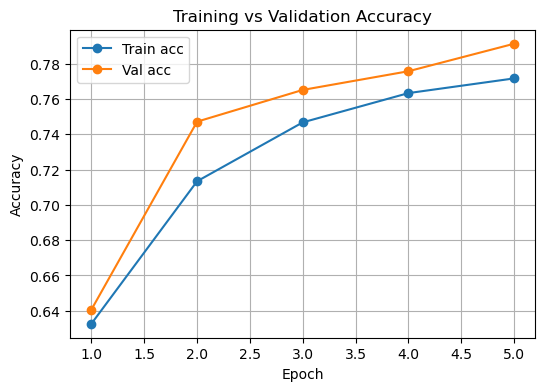

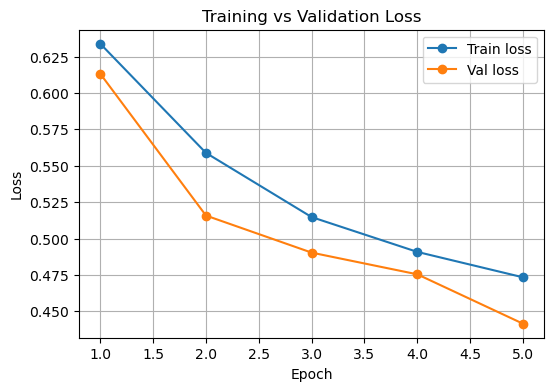

In [13]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

plot_history(history)

In [14]:
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc * 100:.2f}%")


Test loss: 0.4332
Test accuracy: 79.90%


In [15]:
y_true = test_generator.classes
y_prob = model.predict(test_generator).flatten()
y_pred = (y_prob >= 0.5).astype(int)

print("\nConfusion matrix (test):")
y_true = np.array(y_true).astype(int)
print(confusion_matrix(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["cat", "dog"]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step

Confusion matrix (test):
[[2072  428]
 [ 577 1923]]

Classification report:
              precision    recall  f1-score   support

         cat       0.78      0.83      0.80      2500
         dog       0.82      0.77      0.79      2500

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000

